In [1]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('monokai')

# **Loan Default Prediction**

by: Moiez Ismail

#### Table of contents: 
- [Data overview](#Data-overview)
- [Data cleaning](#Data-cleaning)
- [Univariate analysis](#Univariate)
- [Bivariate analysis](#Bivariate)
- [Insights from EDA](#Insights-from-EDA)
- [Executive summary + Solution design proposal](#Executive-summary)

# Loan Default Prediction for Global Bank

## Context
Global Bank (GB) derives profit from interest on loans but faces risks when clients default on their loans (DL). Not every loan that is approved is paid off (GL), and the loan approval process is crucial to minimize defaults and maximize good loans. The bank's decision-making on loan approvals, based on various factors, is not infallible and is subject to human error. To mitigate this, GB is implementing a machine-learning model to assist in the loan approval process.

## Objective
The project aims to develop a machine-learning model capable of predicting loan defaults and pay-offs, providing GB with insights on critical features that should be considered in the loan approval process.

## Key Questions
- What factors are most indicative of a client's likelihood to default?
- Is there a notable difference in certain features between clients who default and those who do not?
- What additional features could enhance the model's explanatory and predictive capabilities?

## Problem Formulation
The task is a binary classification problem focusing on accurately predicting actual defaults (DL) and minimizing false negatives (clients predicted as GL but turn out to be DL).

Also see for further details : - [Model evaluation criterion](#Model-evaluation-criterion)


## Data description
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable that indicates whether an applicant has ultimately defaulted or has been severely delinquent. This adverse outcome occurred in 1,189 cases (20 percent). 12 input variables were registered for each applicant.


* **BAD:** 1 = Client defaulted on loan, 0 = loan repaid

* **LOAN:** Amount of loan approved.

* **MORTDUE:** Amount due on the existing mortgage.

* **VALUE:** Current value of the property. 

* **REASON:** Reason for the loan request. (HomeImp = home improvement, DebtCon= debt consolidation which means taking out a new loan to pay off other liabilities and consumer debts) 

* **JOB:** The type of job that loan applicant has such as manager, self, etc.

* **YOJ:** Years at present job.

* **DEROG:** Number of major derogatory reports (which indicates a serious delinquency or late payments). 

* **DELINQ:** Number of delinquent credit lines (a line of credit becomes delinquent when a borrower does not make the minimum required payments 30 to 60 days past the day on which the payments were due). 

* **CLAGE:** Age of the oldest credit line in months. 

* **NINQ:** Number of recent credit inquiries. 

* **CLNO:** Number of existing credit lines.

* **DEBTINC:** Debt-to-income ratio (all your monthly debt payments divided by your gross monthly income. This number is one way lenders measure your ability to manage the monthly payments to repay the money you plan to borrow.

## **Import the necessary libraries and data**

In [3]:
import plotly.io as pio
pio.renderers.default = "svg"
import pandas as pd
import uuid
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns  
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
#statistics
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import skew, pearsonr, normaltest, ttest_ind, f_oneway, chisquare, chi2_contingency, shapiro


## Data overview
1. understanding the shape of data, data types and missing values
2. checking for duplicated values
3. creating numerical and categorical column names lists
4. having a look at the summary statistics of the numerical columns

In [4]:
data = pd.read_csv('/Users/moiezismail/projects/loan/loan.csv')
loan = data.copy() # Creating a copy of the original variable in case we need to go back to the original dataset

In [5]:
# Let's a look of a sample of the dataframe
loan.sample(5)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
2282,0,13900,84427.0,114209.0,HomeImp,ProfExe,12.0,0.0,2.0,180.187422,0.0,27.0,33.351870
363,0,6300,55000.0,69000.0,DebtCon,ProfExe,13.0,0.0,0.0,130.066667,0.0,20.0,NaN
5707,1,41700,NaN,854114.0,HomeImp,Other,18.0,0.0,0.0,189.099378,1.0,23.0,43.258779
4127,0,21500,67377.0,86502.0,DebtCon,Office,5.0,NaN,NaN,158.640707,NaN,15.0,37.754843
1022,0,9500,47019.0,59413.0,DebtCon,Other,4.0,0.0,0.0,78.025552,0.0,11.0,31.418132


In [6]:
# Decimal values are quite large so let's clean it up to just 2 decimal places

loan = np.round(loan,2)

In [7]:
# The info method gives us the shape as well as the data types in one place
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [8]:
# Code to find out the % of missing values for each column 
np.round(loan.isnull().sum() / len(loan.isnull()) * 100)

BAD         0.0
LOAN        0.0
MORTDUE     9.0
VALUE       2.0
REASON      4.0
JOB         5.0
YOJ         9.0
DEROG      12.0
DELINQ     10.0
CLAGE       5.0
NINQ        9.0
CLNO        4.0
DEBTINC    21.0
dtype: float64

**Observations**
1. the only variables that don't have missing values are: BAD and LOAN
2. the MORTDUE, YOJ, DEROG, and DEBTINC variables have many missing variables
3. will create drop null values in the REASON category as NULL does not mean = lack of a value. When someone is taking out a loan(there must be some reason but may not fit into home improvement or debt reconciliation but 'other' as a category is not helpful or explanatory 
5. For JOB, I will drop null values since the bank would not approve a loan to unmployed individuals or people who do not have a business etc. but i CANNOT just impute a value such as 'Other' since that is not explanatory

In [9]:
loan.duplicated().sum()

0

No duplicate values

#### Summary statistics

In [10]:
np.round(loan.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
BAD,5960.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
LOAN,5960.0,18607.97,11207.48,1100.00,11100.00,16300.00,23300.00,89900.00
MORTDUE,5442.0,73760.82,44457.61,2063.00,46276.00,65019.00,91488.00,399550.00
VALUE,5848.0,101776.05,57385.78,8000.00,66075.50,89235.50,119824.25,855909.00
YOJ,5445.0,8.92,7.57,0.00,3.00,7.00,13.00,41.00
DEROG,5252.0,0.25,0.85,0.00,0.00,0.00,0.00,10.00
DELINQ,5380.0,0.45,1.13,0.00,0.00,0.00,0.00,15.00
CLAGE,5652.0,179.77,85.81,0.00,115.12,173.47,231.56,1168.23
NINQ,5450.0,1.19,1.73,0.00,0.00,1.00,2.00,17.00
CLNO,5738.0,21.30,10.14,0.00,15.00,20.00,26.00,71.00


**Observations**
1. The target variable, BAD, has an average of 0.20 which means 20% of clients are DL and 80% of GL
2. DEBTINC : the mean and median are the exact same(indicating a normal distribution) so I'll use that to impute the NULLs 
2. The average loan amount approved is 18,607 USD with the highest value approved almost 90,000
3. The range for Mortage due on the house is quite wild since the highest value is almost 400k USD with a standard deviation of 44k USD
4. Years on job avearges at around 9 years with a standard deviation at almost the same amount indicating quite a large range for the interquartile range
5. DEROG, DELINQ, NINQ are small value range so I'll use countplots for visualization
6. CLNO is not a high but not as low as the small range variables so I'll use the mean to impute values

Based on the summary stats as well as amount of missing values, I'll create a sister dataset in which the only treatment will be dropping of null values to test its performance on the models against a treated dataset

In [11]:
loan2 = loan.copy()

## EDA:

1. Data cleaning: dealing with null and outliers
1. Univariate
2. Bivariate
3. Multivariate 

### Data cleaning:
1. Loan1 is with imputed values 2) Loan2 is nullvalues dropped

In [12]:
# Let's create a categorical variable for the defaulting status of clients
loan['Status'] = loan['BAD'].apply(lambda x: 'Good' if x == 0 else 'Default')

In [13]:
# A dataframe for the averages of all variables against the defaulting status 
np.round(loan.groupby(['Status']).mean(),2).T

Status,Default,Good
BAD,1.00,0.00
LOAN,16922.12,19028.11
MORTDUE,69460.45,74829.25
VALUE,98172.85,102595.92
YOJ,8.03,9.15
DEROG,0.71,0.13
DELINQ,1.23,0.25
CLAGE,150.19,187.00
NINQ,1.78,1.03
CLNO,21.21,21.32


### Treating Outliers

Outliers will affect the model's performance and this dataset has many so let's deal with them. 

In [14]:
def treat_outliers(df,col):
    '''
    treats outliers in a variable
    df: data frame
    col: name of the column
    '''
    
    Q1=df[col].quantile(0.25) # 25th quantile
    Q3=df[col].quantile(0.75)  # 75th quantile
    IQR=Q3 - Q1   # IQR Range
    lower_lim = Q1 - (1.5 * IQR) #define lower limit
    upper_lim = Q3 + (1.5 * IQR)  # define upper limit
    
    df[col] = np.clip(df[col], lower_lim, upper_lim)
    return df
# all the values smaller and larger than the limits will be dropped  

def treat_outliers_all(df, col_list):
    '''
    treat outlier in all numerical varaibles
    col_list: list of numerical variables
    df: data frame
    '''
    for c in col_list:
        df = treat_outliers(df, c)
        
    return df

num_col = ['LOAN','MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
loan = treat_outliers_all(loan, num_col)

### Treating Missing Values

### Imputing values using measures of central tendency
1. For the low value numerical variables: DEROG, DELINQ, and NINQ, I believe the average would be better than the median because the values do not go very far int the upper ranges and most values are 0
2. For the other numerical variables, the distributions are not normal, and skewed so median would be a more accurate measure
3. For the categorical variables, I will not impute the most common value, instead, another category will be created since it's not possible for a registered client to be approved for a loan without a reason.

In [15]:
loan['VALUE'] = loan['VALUE'].replace(np.nan, loan.VALUE.median())
loan['MORTDUE'] = loan['MORTDUE'].replace(np.nan, loan.MORTDUE.median())
loan['YOJ'] = loan['YOJ'].replace(np.nan, loan.YOJ.median())
loan['DEBTINC'] = loan['DEBTINC'].replace(np.nan, loan.DEBTINC.median())
loan['CLNO'] = loan['CLNO'].replace(np.nan, loan.CLNO.median())
loan['CLAGE'] = loan['CLAGE'].replace(np.nan, loan.CLAGE.median())
loan['DEROG'] = loan['DEROG'].replace(np.nan, loan.DEROG.median())
loan['NINQ'] = loan['NINQ'].replace(np.nan, loan.NINQ.median())
loan['DELINQ'] = loan['DELINQ'].replace(np.nan, loan.DELINQ.mean())

loan = loan.dropna(subset=['JOB'])
loan = loan.dropna(subset=['REASON'])
loan = loan[loan['JOB'] != 'Other']

### Dropping all null values from the sister-dataset Loan2 to test 
### its performance against the dataset Loan 1
loan2 = loan2.dropna()

In [16]:
np.round(loan.isnull().sum() / len(loan.isnull()) * 100)

BAD        0.0
LOAN       0.0
MORTDUE    0.0
VALUE      0.0
REASON     0.0
JOB        0.0
YOJ        0.0
DEROG      0.0
DELINQ     0.0
CLAGE      0.0
NINQ       0.0
CLNO       0.0
DEBTINC    0.0
Status     0.0
dtype: float64

In [17]:
loan.sample(3)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,Status
4077,0,21300,94642.0,125062.0,DebtCon,Office,24.0,0.0,0.0,278.69,2.0,17.0,32.99,Good
5355,0,30400,46948.0,80473.0,DebtCon,Office,0.0,0.0,0.0,151.60,2.0,19.0,37.75,Good
2800,1,15700,60316.0,80000.0,DebtCon,Mgr,0.2,1.0,0.0,85.20,1.0,23.0,34.82,Default


#### Data is cleaned up, let's start the analysis

In [18]:
loan.describe().T

,count,mean,std,min,25%,50%,75%,max
BAD,3216.0,0.183458,0.387102,0.00,0.00,0.00,0.000000,1.000
LOAN,3216.0,18736.256219,9367.514638,1700.00,11900.00,17200.00,23800.000000,41600.000
MORTDUE,3216.0,80153.443579,38088.671181,2619.00,54559.50,72853.50,101305.250000,159306.000
VALUE,3216.0,111042.182287,46337.403651,12500.00,75955.25,100848.50,139427.750000,200447.375
YOJ,3216.0,8.518843,6.806854,0.00,3.00,7.00,12.000000,28.000
DEROG,3216.0,0.192475,0.699224,0.00,0.00,0.00,0.000000,8.000
DELINQ,3216.0,0.468029,1.135016,0.00,0.00,0.00,0.449442,15.000
CLAGE,3216.0,183.815445,77.441122,0.00,125.09,176.17,230.415000,406.230
NINQ,3216.0,1.039801,1.294192,0.00,0.00,1.00,2.000000,5.000
CLNO,3216.0,22.780162,8.937907,0.00,17.00,22.00,28.000000,42.500


### Export cleaned data as CSV file

In [19]:
loan.to_csv('cleaned_loan.csv', index=False)

### Univariate


#### 1. What is the range of values for the loan amount variable "LOAN"?

In [20]:
print(loan.LOAN.min(),loan.LOAN.max())
print(f"The range of the amount of loan is ${loan.LOAN.max() - loan.LOAN.min()}") 

1700 41600
The range of the amount of loan is $39900


Let's visualize multiple variables normalized distribution within the same graph

Multi-distribution 1

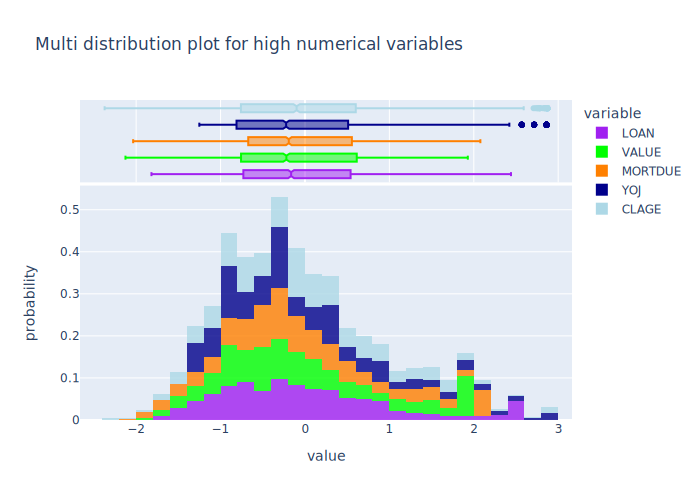

In [21]:
x_vars = ['LOAN', 'VALUE', 'MORTDUE', 'YOJ', 'CLAGE']

# normalize the variables because they're on different scales
loan_norm = (loan[x_vars] - loan[x_vars].mean()) / loan[x_vars].std()

px.histogram(loan_norm, x=x_vars,
             nbins=50, title='Multi distribution plot for high numerical variables',
             histnorm='probability', 
             opacity=0.8, marginal='box', 
             color_discrete_sequence=['#A020F0', '#00FF00', '#FF8000', '#00008B', '#ADD8E6'])

Multi-distribution 2

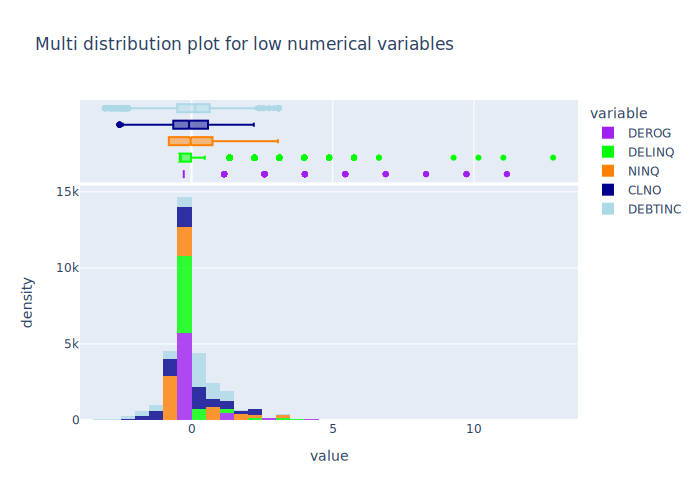

In [22]:
x2_vars = ['DEROG', 'DELINQ', 'NINQ', 'CLNO', 'DEBTINC']

# normalize the variables because they're on different scales
loan_norm2 = (loan[x2_vars] - loan[x2_vars].mean()) / loan[x2_vars].std()

px.histogram(loan_norm2, x=x2_vars,
             nbins=50, title='Multi distribution plot for low numerical variables',
             histnorm='density', 
             opacity=0.8, marginal='box', 
             color_discrete_sequence=['#A020F0', '#00FF00', '#FF8000', '#00008B', '#ADD8E6'])

**Observations**
1. Multi-distribution 1 : visually there is a left skew as the mean seems to be a little less than 0 for pretty much all of the variables. 
2. The mean will be smaller than the median in these distributions.
3. There seems to be a colinearity where CLAGE, YOJ, MORTDUE all follow a similar distribution such as the mode being just lower than 0.
4. Multi-distribution 2: most values sem to be around the middle but the distribution is skewed as shown by the statistical test for normality

Let's find out the stats summary for these numerical variables to have a quick look at the numbers

In [23]:
print('LOAN summary:')
print(np.round(loan.LOAN.describe(),2))
print('-'*30)
print('VALUE summary:')
print(np.round(loan.VALUE.describe(),2))
print('-'*30)
print('MORTDUE summary:')
print(np.round(loan.MORTDUE.describe(),2))
print('-'*30)
print('YOJ summary:')
print(np.round(loan.YOJ.describe(),2))
print('-'*30)
print('CLAGE summary:')
print(np.round(loan.CLAGE.describe(),2))
print('-'*30)
print('DEROG summary:')
print(np.round(loan.DEROG.describe(),2))
print('-'*30)
print('DELINQ summary:')
print(np.round(loan.DELINQ.describe(),2))
print('-'*30)
print('CLNO summary:')
print(np.round(loan.CLNO.describe(),2))
print('-'*30)

LOAN summary:
count     3216.00
mean     18736.26
std       9367.51
min       1700.00
25%      11900.00
50%      17200.00
75%      23800.00
max      41600.00
Name: LOAN, dtype: float64
------------------------------
VALUE summary:
count      3216.00
mean     111042.18
std       46337.40
min       12500.00
25%       75955.25
50%      100848.50
75%      139427.75
max      200447.38
Name: VALUE, dtype: float64
------------------------------
MORTDUE summary:
count      3216.00
mean      80153.44
std       38088.67
min        2619.00
25%       54559.50
50%       72853.50
75%      101305.25
max      159306.00
Name: MORTDUE, dtype: float64
------------------------------
YOJ summary:
count    3216.00
mean        8.52
std         6.81
min         0.00
25%         3.00
50%         7.00
75%        12.00
max        28.00
Name: YOJ, dtype: float64
------------------------------
CLAGE summary:
count    3216.00
mean      183.82
std        77.44
min         0.00
25%       125.09
50%       176.17
75%  

Let's perform a skew test to test whethere this data is normally distrubted or not from a statistical perspective

State the hypothesis:
* $H_0:$ There is no skewness, the variables are normally distributed
* $H_1:$ There is skewness, the variables are not normally distributed

alpha = 0.05

In [24]:
from scipy.stats import normaltest, skewtest

def test_normality(data):
    # Skew test
    skew_test_num = [
        ('LOAN', stats.skewtest(data['LOAN'])[1]),
        ('VALUE', stats.skewtest(data['VALUE'])[1]),
        ('MORTDUE', stats.skewtest(data['MORTDUE'])[1]),
        ('YOJ', stats.skewtest(data['YOJ'])[1]),
        ('CLAGE', stats.skewtest(data['CLAGE'])[1]),
        ('DEROG', stats.skewtest(data['DEROG'])[1]),
        ('DELINQ', stats.skewtest(data['DELINQ'])[1]),
        ('NINQ', stats.skewtest(data['NINQ'])[1]),
        ('CLNO', stats.skewtest(data['CLNO'])[1]),
        ('DEBTINC', stats.skewtest(data['DEBTINC'])[1])
    ]
    # for loop to print out the name of the variable and whether or not it's skewed based on the skew-test
    for var, pval in skew_test_num:
        if pval < 0.05:
            print(var, "is skewed")
        else:
            print(var, "is NOT skewed")

    # Normal test
    normal_test_list = [
        ('LOAN', stats.normaltest(data['LOAN'])[1]),
        ('VALUE', stats.normaltest(data['VALUE'])[1]),
        ('MORTDUE', stats.normaltest(data['MORTDUE'])[1]),
        ('YOJ', stats.normaltest(data['YOJ'])[1]),
        ('CLAGE', stats.normaltest(data['CLAGE'])[1]),
        ('DEROG', stats.normaltest(data['DEROG'])[1]),
        ('DELINQ', stats.normaltest(data['DELINQ'])[1]),
        ('NINQ', stats.normaltest(data['NINQ'])[1]),
        ('CLNO', stats.normaltest(data['CLNO'])[1]),
        ('DEBTINC', stats.normaltest(data['DEBTINC'])[1])
    ]
    print("-"*30)
    # for loop to print out the name of the variable and whether or not it's normal based on the normal-test
    for var, pval in normal_test_list:
        if pval < 0.05:
            print(var, "is NOT normal")
        else:
            print(var, "is normal")
            
test_normality(loan)

LOAN is skewed
VALUE is skewed
MORTDUE is skewed
YOJ is skewed
CLAGE is skewed
DEROG is skewed
DELINQ is skewed
NINQ is skewed
CLNO is skewed
DEBTINC is skewed
------------------------------
LOAN is NOT normal
VALUE is NOT normal
MORTDUE is NOT normal
YOJ is NOT normal
CLAGE is NOT normal
DEROG is NOT normal
DELINQ is NOT normal
NINQ is NOT normal
CLNO is NOT normal
DEBTINC is NOT normal


**Observations**
1. all variables are not-normally distributed and skewed

Function for plotting the distributions as a histogram with a boxplot 

In [25]:
import plotly.express as px

def plot_histogram(variable):
    variable_name = variable.name
    fig = px.histogram(loan, x=variable, marginal='box', text_auto=True,
                       labels={variable_name: variable_name.capitalize(), 'count': 'Count'},
                       color_discrete_sequence=['green'],
                       title=f"Distribution of {variable_name.capitalize()}")
    fig.show()

**Observation** 
1. Looks like a LOAN is mostly all centered between 11K and 23K
2. The value of the houses follow a very similar pattern in that most of it is centered around the middle with a high value at the top

#### 2. How does the distribution of years at present job "YOJ" vary across the dataset?
**Observations** 
1. The average is about 9 years with a large standard deviation close to the average at 7 and a half years
2. The minimum is strage as it is in 0 years which does not make sense but it could be that it's less than a year of working at their current job
3. The most years working at current job tops out at 41 years

#### 3. How many unique categories are there in the REASON variable?

In [26]:
loan.REASON.nunique()

2

**Observations**
1. I find it strange that there weren't more than 2 categories, or an 'Other' category as surely there must be more than 2 reasons to take out a loan
2. JOB and REASON variables will be one-hot encoded later for the models

#### 4. What is the most common category in the JOB variable?

In [27]:
loan['JOB'].value_counts()

ProfExe    1252
Office      921
Mgr         746
Self        188
Sales       109
Name: JOB, dtype: int64

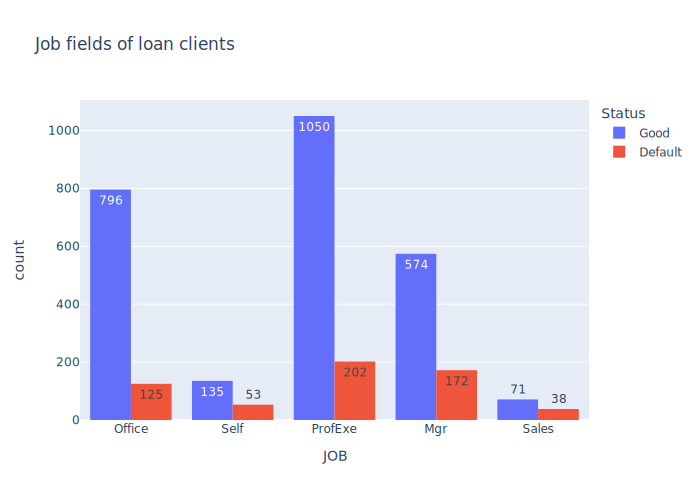

In [28]:
px.histogram(loan, x='JOB', title='Job fields of loan clients',
             color='Status', barmode='group',text_auto=True)

**Observations**
1. In both good and default status, Prof ex make up the largest portion but Office jobs make up the 2nd largest portion in good loans unlike in defaulting where Managers up the 2nd largest
2. Self-employed is the least common job of clients who take out a loan

In [29]:
np.round(loan['DEBTINC'].describe().T,2)

count    3216.00
mean       33.98
std         6.40
min        14.35
25%        30.73
50%        34.82
75%        38.11
max        53.79
Name: DEBTINC, dtype: float64

**Observations**
1. This data seems to be left skewed meaning as the ratio of debt to income increases, we find more and more people in that level with around 35 being the most common. 
2. The max value is more than 3x the standard deviation value at 53.8

### Bivariate
1. The target variable is BAD, but I will use Status in order to make visualization easier
2. It is not necessary to look at the correlation between all variables; I will use the target variable with other features to perform the bivariate analysis

#### 5. Is there a relationship between the REASON variable and the proportion of applicants who defaulted on their loan?

Let's answer that with a chi-squared hypothesis test: 

State the hypothesis:
* $H_0:$ There is no relationship between the two Reasons and loan status.  
* $H_1:$ There is a statistically significant relationship between between the reasons for taking out a loan and whethere or not the loan will be paid of

alpha = 0.05

In [30]:
from scipy.stats import chi2_contingency

reason_status_cont = pd.crosstab(loan['Status'], loan['REASON'])

status_reason = chi2_contingency(reason_status_cont)[1]

if status_reason < 0.05:
    print('Evidence to reject the null hypothesis, there is a relationship between the two variables')
else:
    print('Evidence is not sufficient to reject the null, there is no significant relationship')

Evidence is not sufficient to reject the null, there is no significant relationship


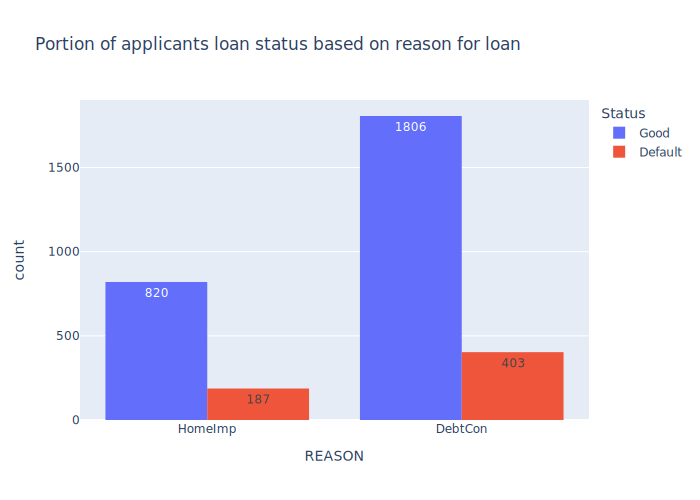

In [31]:
px.histogram(loan, x='REASON', 
             color='Status', 
             barmode='group', 
             text_auto=True, title='Portion of applicants loan status based on reason for loan')

**Observations**
1. This questions is tough to answer because we do not have the same number of clients who take a loan out for the same reasons 
2. For both people who took a loan for home improvement and defaulted(187) vs. those who took it out for debt consolidation(403)
2. An overwhelming people take out a loan for debt consolidation and paid it off. 

Let's see if the # of derogatory reports(which probably includes the delinquent payments) has any relationship 
with the status of loans

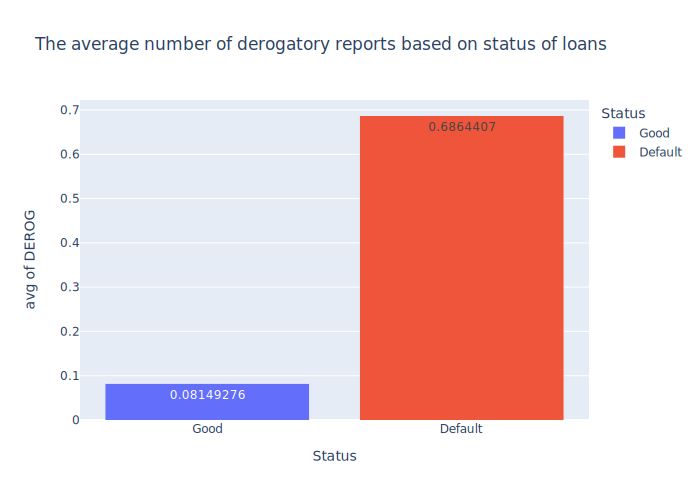

In [108]:
px.histogram(loan, x='Status', y='DEROG',
             color='Status', 
             histfunc='avg', 
             text_auto=True, title='The average number of derogatory reports based on status of loans')

**Observations**
1. This is quite an overwhelming difference in the average of GL at 0.08 and DL at 0.7

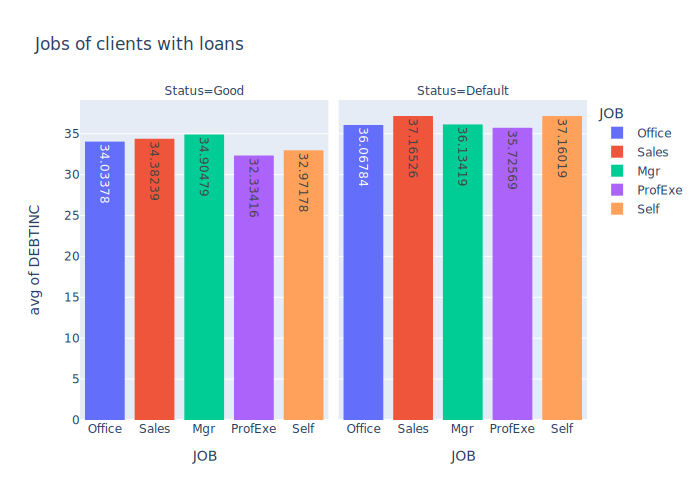

In [109]:
px.histogram(loan, title='Jobs of clients with loans', y='DEBTINC',
             x='JOB', histfunc='avg',color='JOB', facet_col="Status",
             text_auto=True)

**Observations**
1. There doesn't seem to be any outliers or stark difference between the jobs and their average Debt to income ratio for both default and good status clients. 

**Observation**
1. There isn't really a correlation for either variable
2. THe good status loans have a slight negative correlation between size of loan and years worked at current job
3. For defaulted clients, it's the opposite

### Linear regression analysis 
Let's have a look at the debt to income ratio and the size of the loan and see if there is a relationship between good and defaulted loans

In [110]:
X = sm.add_constant(loan['LOAN'])
y = loan['DEBTINC']
model = sm.OLS(y, X).fit()
loan['best_fit'] = model.predict(X)

print(f"The R^2 value is: {round(model.rsquared,3)}")

The R^2 value is: 0.007


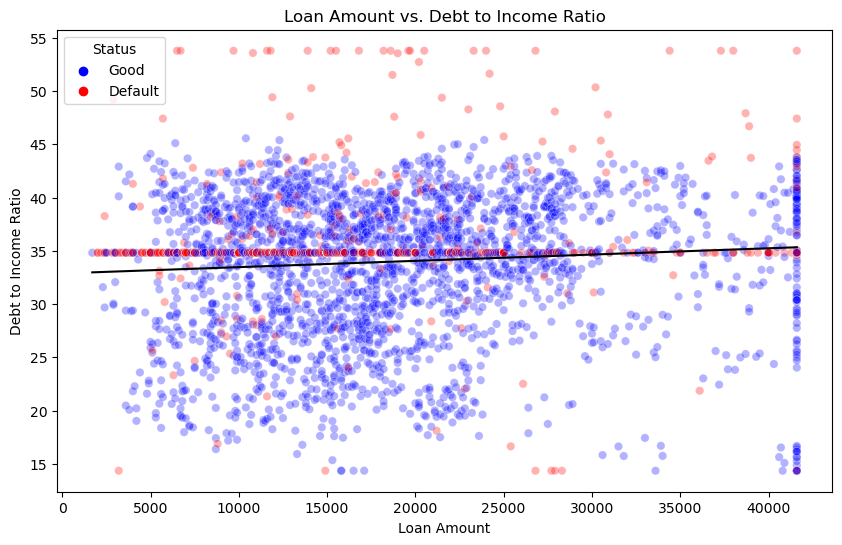

In [111]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=loan, x='LOAN', y='DEBTINC', hue='Status', alpha=0.3,
               palette={'Good':'blue','Default':'red'})

# Add the trend line
plt.plot(loan['LOAN'], loan['best_fit'], color='black')

# Set title and labels
plt.title('Loan Amount vs. Debt to Income Ratio')
plt.xlabel('Loan Amount')
plt.ylabel('Debt to Income Ratio')
plt.show()

## Bivariate Analysis: Loan Amount vs. Debt to Income Ratio
Using linear regression, we analyzed the relationship between the loan amount (`LOAN`) and the debt to income ratio (`DEBTINC`), considering loan status (`BAD`). The resulting R-squared value of 0.007 indicates a weak linear relationship, suggesting that the loan amount is not a strong predictor of the debt-to-income ratio. Interestingly, defaulted loans tend to have a higher debt-to-income ratio, pointing to other contributory factors to loan default.

#### 6. Do applicants who default have a significantly different loan amount compared to those who repay their loan?

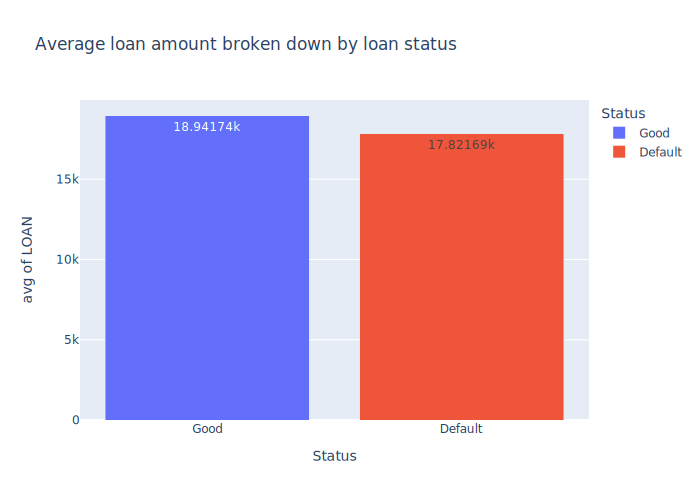

In [112]:
px.histogram(loan, histfunc='avg', title='Average loan amount broken down by loan status', 
             x='Status', y='LOAN', color='Status', text_auto=True)

In [113]:
np.round((loan[loan['Status'] ==
               'Good']['LOAN'].mean()) - (loan[loan['Status'] == 'Default']['LOAN'].mean()),2)                                                                  

1120.04

**Observations**
1. Surprisingly, the average for defaulting loan amount is smaller than the good status loans.
2. only about a 1100 dollar difference between the averages

Let's answer with a Mann-Whitney U test since LOAN is not normally distributed: 

State the hypothesis:
* $H_0:$ The average approved loan is defaulting and good clients are statistically the same.   
* $H_1:$ There is a statistically significant difference bewteen the average of clients who default and good clients

alpha = 0.05

In [114]:
# Since LOAN is not normally distributed, we have to use the mann-whitney U test

default_loan = loan[loan['Status'] == 'Default']['LOAN']
good_loan = loan[loan['Status'] == 'Good']['LOAN']

stat, p = stats.mannwhitneyu(default_loan, good_loan) # Conducting the test 

if p < 0.05:
    print('Sufficient evidence to reject the null hypothesis')
else:
    print('Not enough evidence to reject the null hypothesis')

Sufficient evidence to reject the null hypothesis


**Observation**
1. SO even though it is only about 1.1k, it is a significant difference

#### 7. Is there a correlation between the value of the property and the loan default rate?

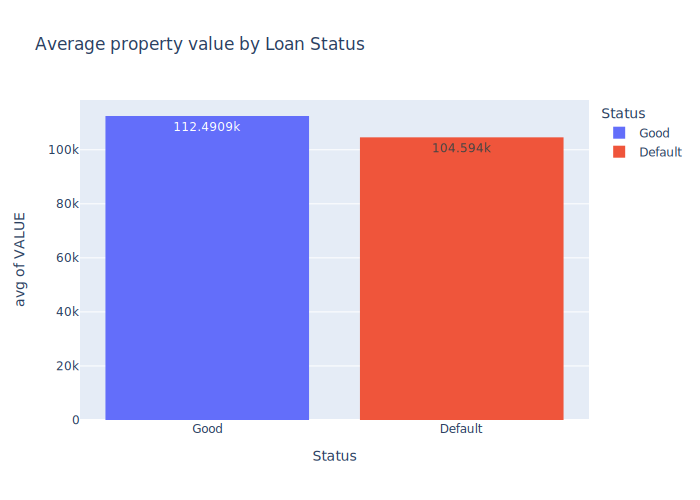

In [115]:
px.histogram(loan, x='Status', y='VALUE' ,color='Status',
             histfunc='avg',
             text_auto=True, labels={'avg of VALUE':'Average value of property'},
             title=' Average property value by Loan Status')


Let's answer that with a similar test: 

State the hypothesis:
* $H_0:$ The average value of property between good and defaulting clients are statistically the same.   
* $H_1:$ There is a statistically significant difference bewteen the average property value of good and defaulting clients

alpha = 0.05

In [116]:
default_value = loan[loan['Status'] == 'Default']['VALUE']
good_value = loan[loan['Status'] == 'Good']['VALUE']

stat, p = stats.mannwhitneyu(default_value, good_value) 
if p < 0.05:
    print('Sufficient evidence to reject the null hypothesis')
else:
    print('Not enough evidence to reject the null hypothesis')

Sufficient evidence to reject the null hypothesis


In [117]:
np.round(good_value.mean() - default_value.mean())

7897.0

**Observations**
1. Similar to the relationship between Loan amount and default rate, there isn't a stark visual difference in the average property value of good and defaulting clients but statistically there is a difference. 
2. The average value of property of good clients is 7.9k higher than defaulting clients

#### 8. Do applicants who default have a significantly different mortgage amount compared to those who repay their loan?

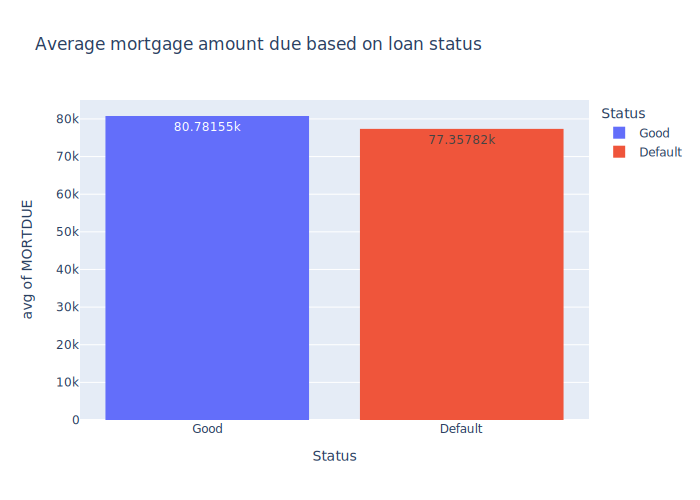

In [118]:
px.histogram(loan, x='Status', title='Average mortgage amount due based on loan status', 
             color='Status', text_auto=True, y='MORTDUE', histfunc='avg')

Let's answer that with another mann-whitney test since MORTDUE is not normally distributed either: 

State the hypothesis:
* $H_0:$ The average mortgage left on the property between good and defaulting clients are statistically the same. 
* $H_1:$ There is a statistically significant difference bewteen the average mortgage left bewteen good and defaulting clients

alpha = 0.05

In [119]:
default_mort = loan[loan['Status'] == 'Default']['MORTDUE']
good_mort = loan[loan['Status'] == 'Good']['MORTDUE']

stat, p = stats.mannwhitneyu(default_mort, good_mort) 

if p < 0.05:
    print('Sufficient evidence to reject the null hypothesis')
else:
    print('Not enough evidence to reject the null hypothesis')

Sufficient evidence to reject the null hypothesis


In [120]:
np.round(good_mort.mean() - default_mort.mean())

3424.0

**Observations**
1. Based on a visual, there isn't a big difference at all  but this 3.4K difference is statistically significant so we can reject the null hypothesis
2. Just like property value of house and loan amount, mortgage due is also higher for good status loans.

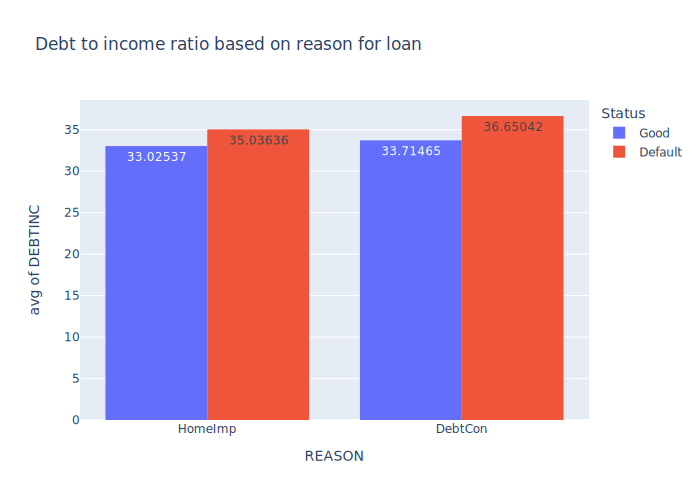

In [44]:
px.histogram(loan, x='REASON', color='Status', barmode='group', histfunc='avg',
             y='DEBTINC', text_auto=True, title='Debt to income ratio based on reason for loan')

**Observations**
1. The average debt to income ratio is higher for DL than GL for both home improvement and debt reconciliation loans

### **Multivariate Analysis**

First, let's make a mini dataframe of all the averages of all numerical columns grouped by status in vertical form

In [121]:
import plotly.io as pio

fig = px.imshow(np.round(loan.corr(),2),
                range_color=[-1, 1],
                text_auto=True, title='Correlation heat map of all numerical variables',
                color_continuous_scale='RdBu')
fig.update_layout(width=800, height=600)
fig.write_image("heatmap.png")

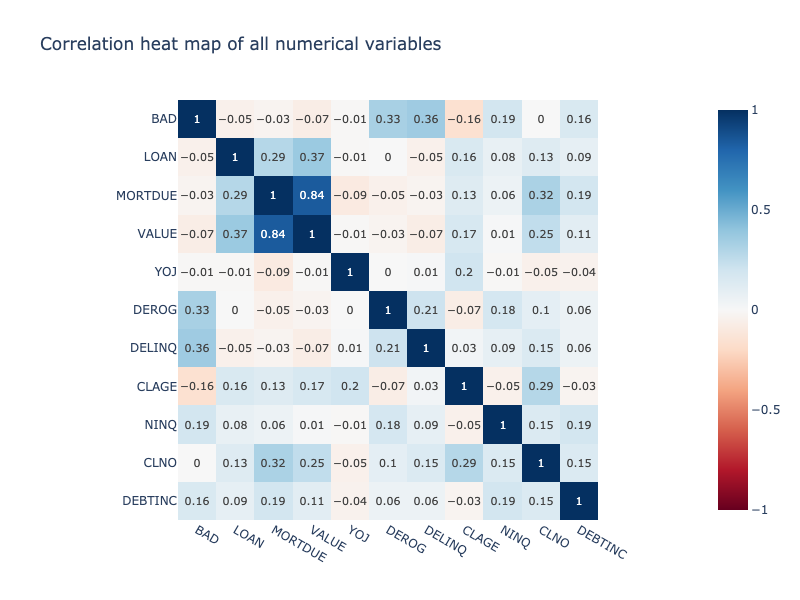

**Observations**
1. There aren't any correlations of significance with resepcts to the loan status(BAD) category
2. the only strong correlation is with BAD(loan status) is DEROG and DELINQ but they are still quite weak correlations

## Insights from Exploratory Data Analysis (EDA)

- Financial metrics exhibit right skewness, indicating a risk of outliers and a potential focus of defaults.
- `LOAN`, `VALUE`, and `MORTDUE` are correlated but do not show distinct variations across loan statuses.
- Higher loan amounts among defaulting clients suggest more complex financial challenges than what loan values can reveal.
- Debt consolidation loans exhibit a higher default rate compared to home improvement loans, indicating a potential area for more stringent risk assessment.
- Additional data on income, household size, job types, and loan purposes could improve the predictability of loan defaults.

## Executive Summary

- Global Bank (GB) needs to enhance its loan risk assessment protocols. Our analysis reveals subtle yet significant variations in financial indicators for defaulted loans, pointing to the intricacies involved in default prediction.
- The bank is challenged with balancing loan approvals against the risk of defaults and the necessity to accrue interest revenue.
- Differences in loan amounts, debt-to-income ratios, and job categories are minimal but significant between defaulting and non-defaulting clients. More pronounced disparities are observed in derogatory and delinquent reports.

## Recommendations for Implementation

- Accurate collection and calculation of debt-to-income ratios should be prioritized to improve risk assessment accuracy.
- Categorical variables such as job types and loan purposes need further detailing to enhance predictive granularity.
- Optimizing the data structure to more accurately profile clients, especially through credit-related datasets, could lead to better risk prediction.
- Stakeholders must consider the implications of income, employment, and other debts in loan approval processes, recognizing these as potential limitations in current assessment methods.